## Bonus 2

<p>In order to make the task a classification one, we add a new column based on the classification done by WHO. These labels are then processed using Ordinal encoder to make these numerical and store its instance.</p>

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
import functions
import optuna
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.svm import SVR, SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import OrdinalEncoder
from pathlib import Path
from typing import Optional, List

In [2]:
# Get the working directory
input_path = Path.cwd()
root = input_path.parent
data_path = root / "data" / "development_final_data.csv"
train_df = pd.read_csv(data_path, header=0)
# Go to the dev set and drop the target column as well as the columns that are not microbiome related
x = train_df.drop(columns=['BMI', 'Host age', 'Sex_Male'])
# Define y as the target variable
y = train_df['BMI']
# Do the same for the evaluation set
val_df = pd.read_csv(root / "data" / "evaluation_final_data.csv", header=0)
val_x = val_df.drop(columns=['BMI', 'Host age', 'Sex_Male'])
val_y = val_df['BMI']

In [3]:
new_df = functions.add_bmi_category(
    train_df
)
new_val_df = functions.add_bmi_category(
    val_df
)
new_df.head()

,Host age,BMI,Acholeplasma axanthum,Acidaminococcus fermentans,Acidaminococcus intestini,Actinomyces lingnae,Akkermansia muciniphila,Alistipes finegoldii,Alistipes indistinctus,Alistipes obesi,...,Clostridium stercorarium,Clostridium symbiosum,Clostridium thermosuccinogenes,Clostridium xylanolyticum,Eubacterium brachy,Eubacterium dolichum,Eubacterium sulci,Ruminococcus gnavus,Sex_Male,BMI_Category
0,0.400741,19.01,-0.116074,-0.151651,-0.366867,-0.154353,-0.357553,-0.396184,-0.258769,-0.239862,...,-0.178185,-0.497202,-0.161263,-0.315570,-0.357998,-0.129594,-0.214033,0.019673,1.0,Normal weight
1,-1.635900,23.50,-0.108980,-0.151651,-0.366867,-0.154353,2.663768,-0.393737,-0.258769,-0.239862,...,2.108974,-0.481538,-0.170765,-0.315570,0.118380,0.024110,0.196608,-0.210150,0.0,Normal weight
2,0.337096,25.80,-0.106369,-0.151651,-0.366867,-0.019414,-0.361007,-0.077031,-0.258769,-0.239862,...,-0.162598,-0.461486,-0.170765,-0.315570,-0.357998,-0.129594,-0.199298,-0.180683,1.0,Abnormal weight
3,-0.426644,23.49,-0.116074,-0.106995,-0.026565,-0.154353,-0.351405,-0.389180,1.200847,-0.239862,...,-0.178185,0.309746,-0.071131,0.515577,-0.357998,-0.129594,-0.230236,-0.221277,0.0,Normal weight
4,-1.063095,22.60,-0.096208,0.037702,8.788685,-0.154353,-0.158938,-0.396184,-0.258769,-0.239862,...,-0.178185,-0.233995,0.005653,0.368071,0.740698,-0.129594,0.070595,-0.193578,0.0,Normal weight


In [4]:
ordenc = OrdinalEncoder()
new_df['BMI_Category'] = ordenc.fit_transform(new_df['BMI_Category'].values.reshape(-1,1))
ordenc_path = root / "models" / "OrdinalEncoder.pkl"
pickle.dump(ordenc, open(ordenc_path, 'wb'))

In [5]:
with open(ordenc_path, 'rb') as fin: 
    ordenc = pickle.load(fin)
    new_val_df['BMI_Category'] = ordenc.transform(new_val_df['BMI_Category'].values.reshape(-1,1))

In [7]:
final_bonus_df_path = final_val_csv_path = root / "data" / "bonus_dev_final_data.csv"
new_df.to_csv(final_bonus_df_path, index=False)
final_bonus_df_path_eval = final_val_csv_path = root / "data" / "bonus_evaluation_final_data.csv"
new_val_df.to_csv(final_bonus_df_path_eval, index=False)

In [3]:
# Load the new dfs and define x and y variables
final_bonus_df_path = final_val_csv_path = root / "data" / "bonus_dev_final_data.csv"
final_bonus_df_path_eval = final_val_csv_path = root / "data" / "bonus_evaluation_final_data.csv"
classif_dev = pd.read_csv(final_bonus_df_path, header=0)
x = classif_dev.drop(columns=['BMI', 'Host age', 'Sex_Male', 'BMI_Category'])
y = classif_dev['BMI_Category']
classif_val = pd.read_csv(final_bonus_df_path_eval, header=0)
x_val = classif_val.drop(columns=['BMI', 'Host age', 'Sex_Male', 'BMI_Category'])
y_val = classif_val['BMI_Category']

In [5]:
print(f"Normal weight count in dev = {len(classif_dev[classif_dev['BMI_Category']==1.0])}")
print(f"Abnormal weight count in dev = {len(classif_dev[classif_dev['BMI_Category']==0.0])}")
print(f"Normal weight count in val = {len(classif_val[classif_val['BMI_Category']==1.0])}")
print(f"Abnormal weight count in val = {len(classif_val[classif_val['BMI_Category']==0.0])}")

Normal weight count in dev = 228
Abnormal weight count in dev = 261
Normal weight count in val = 93
Abnormal weight count in val = 118


<p>Here we perform kfold cross-validation for the baseline models Logistic Regression and Gaussian Naive Bayes Classifier. As we can see Logistic Regression does not converge many of the times but we finally manage to get results.</p>

LogisticRegression


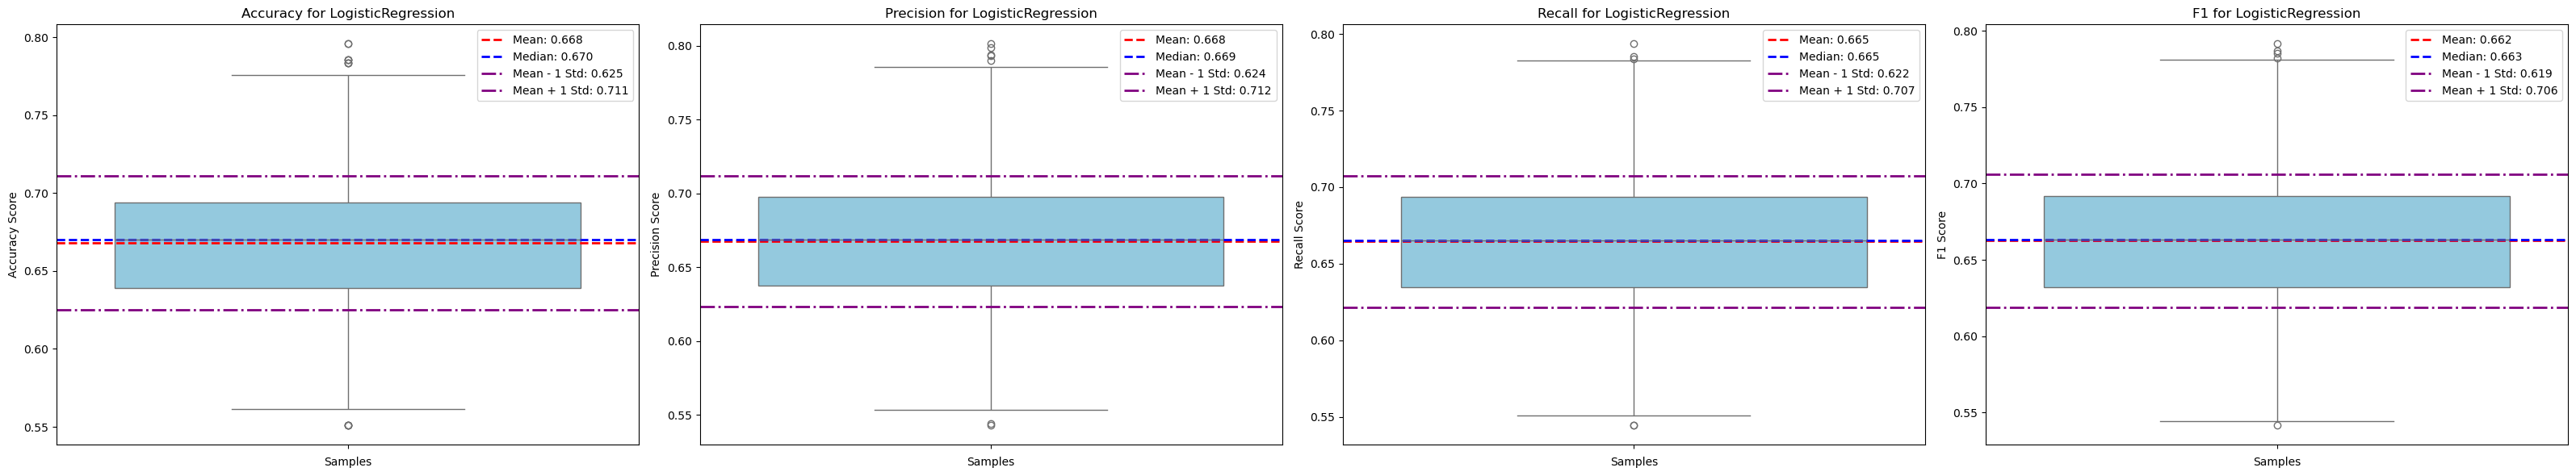

GaussianNB


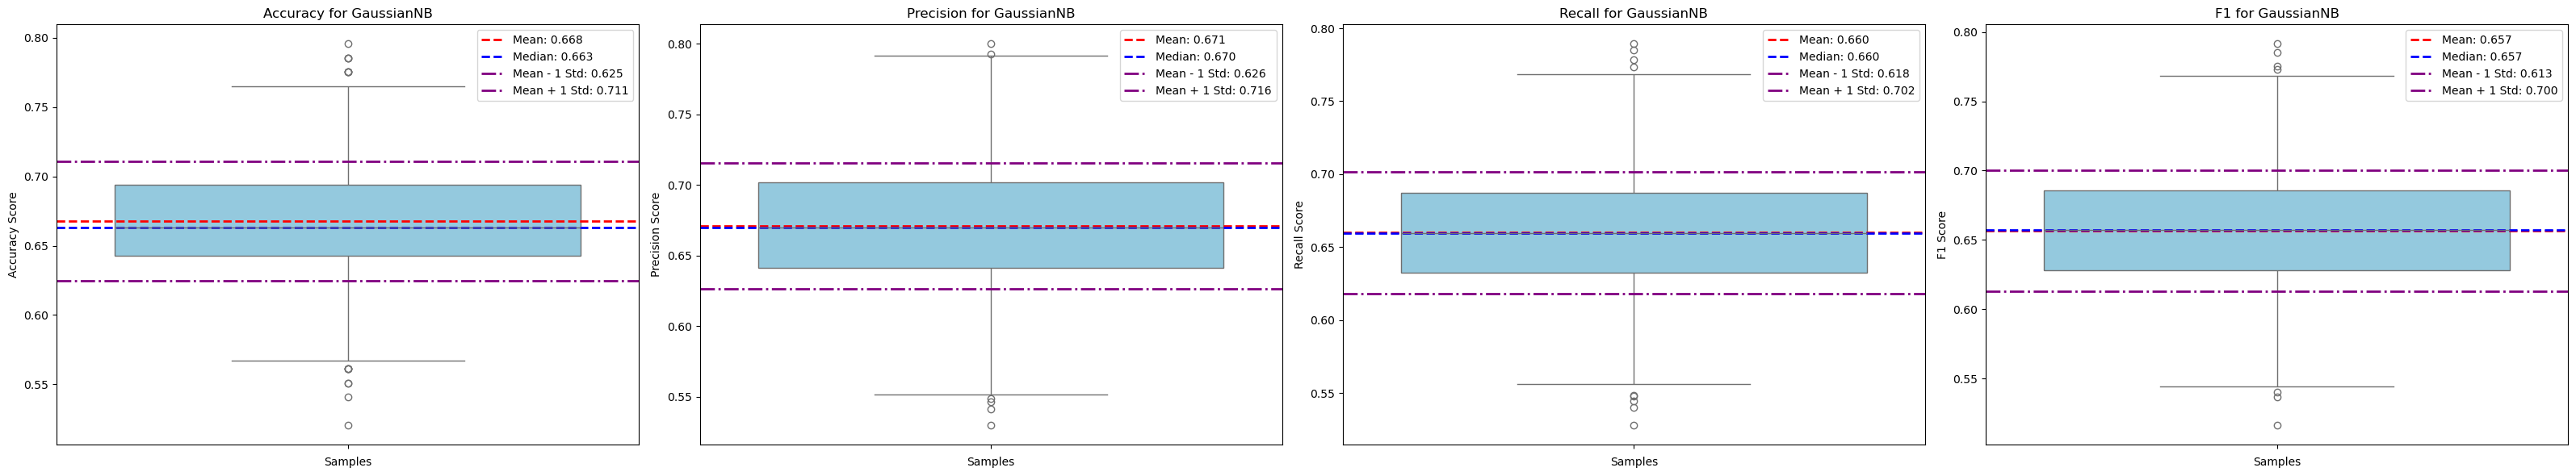

In [17]:
# Perform kfold for the two models
models = [LogisticRegression(), GaussianNB()]
for model in models:
    print(model.__class__.__name__)
    pipeline = functions.create_pipeline(model=model)
    functions.bootstrap2boxplot(
        x, y,
        x_val, y_val,
        pipeline, n_iter=200,
        bstrap=False, kf=True,
        root_path=root,
        filename=f"Bonus2_{model.__class__.__name__}_baseline.pkl",
        save=True, default_path=True,
        classif = True
    )

<p>The results from the kfold cross validation look underwhelming as the accuracy is close to 60% for Logistic Regression with the precision being 45% and recall and F1 significantly less and close to 20%. The results from Gaussian Naive Bayes are worse in comparison, which could be attributed to the severe class imbalance. The same results can be seen in the evaluation below.</p>

LogisticRegression


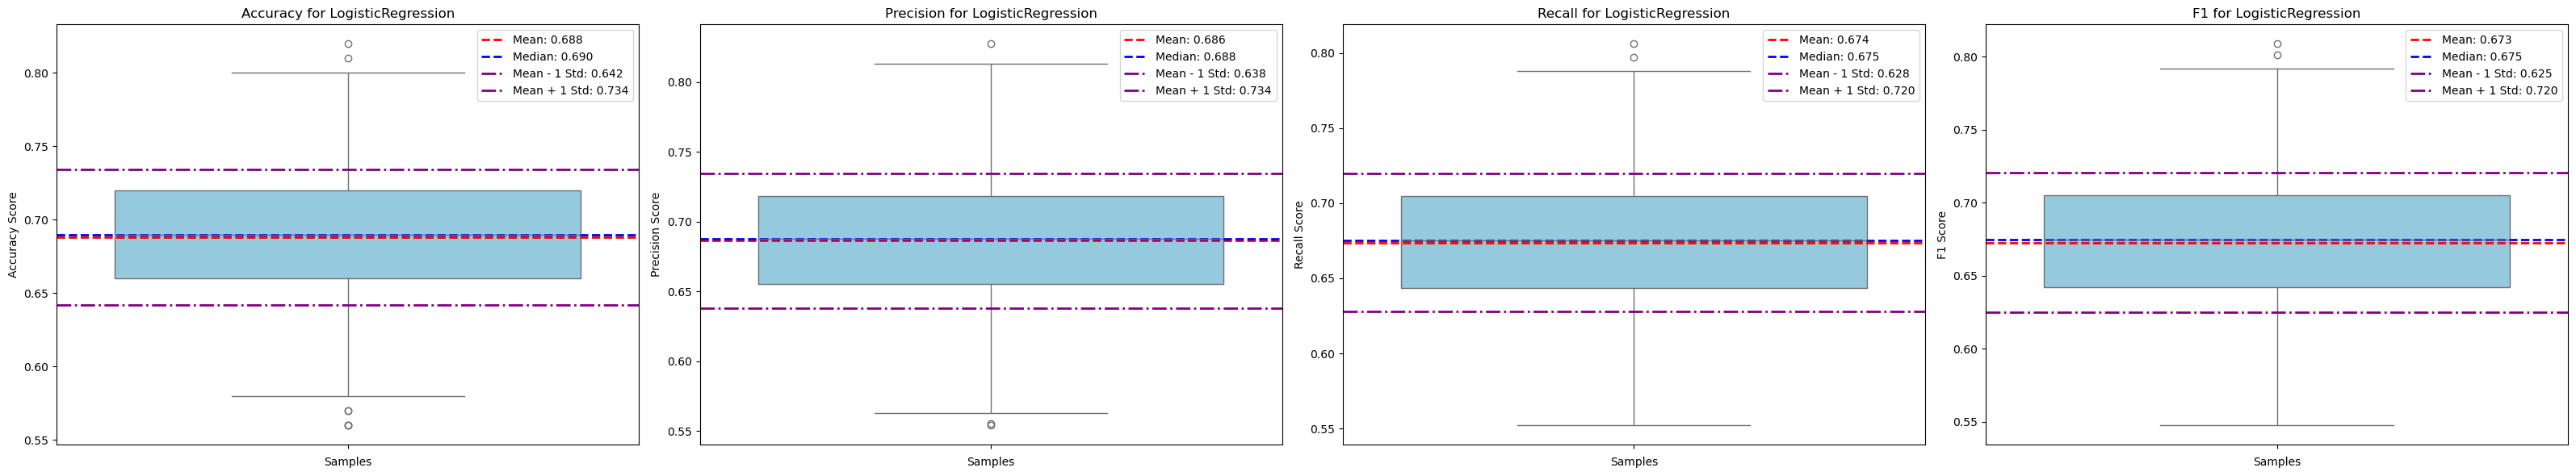

GaussianNB


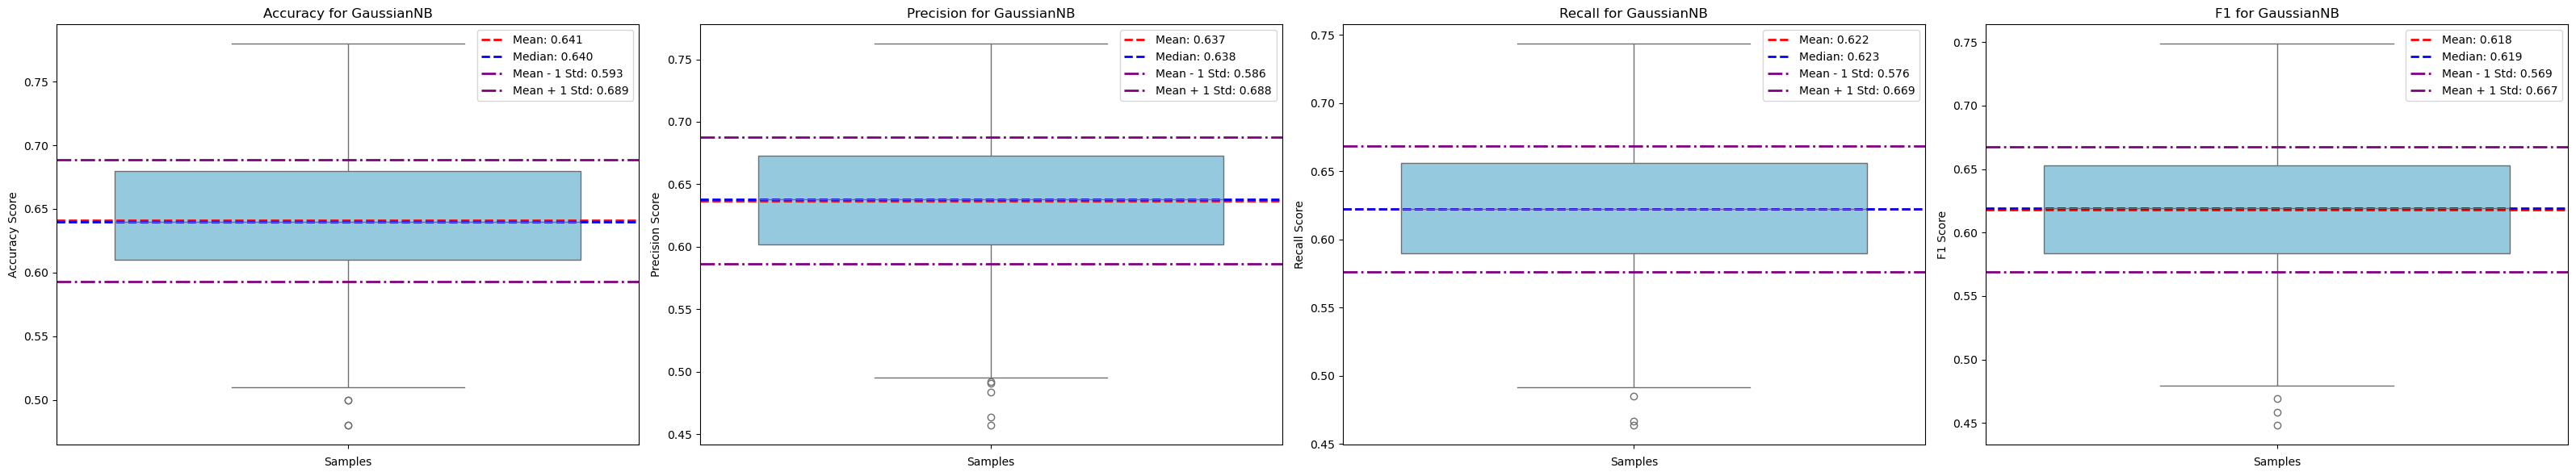

In [18]:
models = [LogisticRegression(), GaussianNB()]
for model in models:
    print(model.__class__.__name__)
    pipeline = functions.create_pipeline(model=model)
    functions.bootstrap2boxplot(
        x, y,
        x_val, y_val,
        pipeline, n_iter=1000,
        bstrap=True, kf=False,
        classif = True, save = False
    )

### Feature selection for Classification

#### RFE

<p>Results from RFE look underwhelming as well given that the recall score is significantly worse than the results coming from the full feature set</p>

LogisticRegression
Optimal number of features: 86
Selected features: ['Acholeplasma axanthum', 'Actinomyces lingnae', 'Akkermansia muciniphila', 'Alistipes finegoldii', 'Alistipes obesi', 'Alistipes onderdonkii', 'Alistipes putredinis', 'Alistipes shahii', 'Alistipes timonensis', 'Anaerostipes caccae', 'Anaerotruncus colihominis', 'Bacillus megaterium', 'Bacteroides eggerthii', 'Bacteroides fragilis', 'Bacteroides intestinalis', 'Bacteroides massiliensis', 'Bacteroides plebeius', 'Bacteroides salyersiae', 'Bifidobacterium bifidum', 'Bifidobacterium pseudocatenulatum', 'Bifidobacterium saguini', 'Bifidobacterium tsurumiense', 'Blautia coccoides', 'Blautia glucerasea', 'Blautia hydrogenotrophica', 'Blautia producta', 'Butyricimonas virosa', 'Catabacter hongkongensis', 'Clostridium amylolyticum', 'Clostridium malenominatum', 'Clostridium sp.', 'Collinsella aerofaciens', 'Collinsella intestinalis', 'Desulfonispora thiosulfatigenes', 'Desulfosporosinus orientis', 'Desulfovibrio fairfieldens

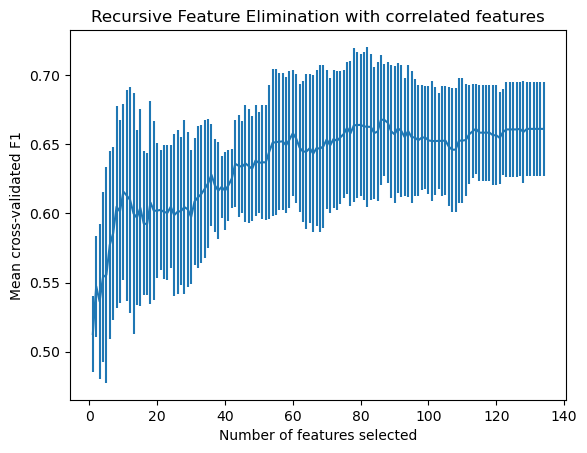

In [21]:
from sklearn.feature_selection import RFECV
models = [LogisticRegression()]
cv = KFold(n_splits=5, shuffle=True, random_state=42)
features_per_model = {}
for model in models:
    features_per_model[model.__class__.__name__] = []
    print(model.__class__.__name__)
    rfecv = RFECV(estimator=model, 
                step=1, cv=cv, 
                scoring='f1_macro',
                min_features_to_select=1
                )
    rfecv.fit(x, y)
    print('Optimal number of features: %d' % rfecv.n_features_)
    # If x is a DataFrame, this will list the selected features by name.
    selected_features = x.columns[rfecv.support_]
    selected_features_list = selected_features.tolist()
    features_per_model[model.__class__.__name__].extend(selected_features_list)
    print("Selected features:", selected_features_list)
    # Number of features tested by RFE:
    n_features_list = np.arange(
        rfecv.min_features_to_select, 
        x.shape[1] + 1,               
        rfecv.step                     
    )
    # Only take as many points as in cv_results_:
    n_features_list = n_features_list[:len(rfecv.cv_results_["mean_test_score"])]
    optimal_index = list(n_features_list).index(rfecv.n_features_)
    optimal_score = rfecv.cv_results_["mean_test_score"][optimal_index]
    print("Mean F1 for optimal features ({}): {:.4f}".format(rfecv.n_features_, optimal_score))
    cv_results = pd.DataFrame(rfecv.cv_results_)
    plt.errorbar(
        x=n_features_list,
        y=cv_results["mean_test_score"],
        yerr=cv_results["std_test_score"],
    )
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean cross-validated F1")
    plt.title("Recursive Feature Elimination with correlated features")
    plt.show()


### Optuna

<p>In order to find the optimal feature selection method we use the same function as before but change the metric to be the recall score. We can see that the results stay largely the same.</p>

In [6]:
models = [LogisticRegression(), GaussianNB()]
for model in models:
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: functions.optuna_dim_reduction(trial, model, x, y, scoring='f1_macro', classif=True), n_trials=100)
    print(study.best_params)
    print(study.best_value)

[I 2025-03-31 18:48:52,279] A new study created in memory with name: no-name-ec0573cd-3086-4cfb-ad2f-8177cb8c9e85
[I 2025-03-31 18:49:02,084] Trial 0 finished with value: 0.6406694200041195 and parameters: {'method': 'SelectKBest', 'sk_method': 'mutual_info_classification', 'k': 52}. Best is trial 0 with value: 0.6406694200041195.
[I 2025-03-31 18:49:03,322] Trial 1 finished with value: 0.6478071662160293 and parameters: {'method': 'KernelPCA', 'kernel': 'rbf', 'n_components': 12}. Best is trial 1 with value: 0.6478071662160293.
[I 2025-03-31 18:49:13,231] Trial 2 finished with value: 0.635436805978336 and parameters: {'method': 'SelectKBest', 'sk_method': 'mutual_info_classification', 'k': 33}. Best is trial 1 with value: 0.6478071662160293.
[I 2025-03-31 18:49:14,289] Trial 3 finished with value: 0.6672332644630242 and parameters: {'method': 'PCA', 'n_components': 92}. Best is trial 3 with value: 0.6672332644630242.
[I 2025-03-31 18:49:15,172] Trial 4 finished with value: 0.653916416

{'method': 'KernelPCA', 'kernel': 'poly', 'degree': 3, 'n_components': 79}
0.6846154780192668


[I 2025-03-31 18:52:41,879] Trial 0 finished with value: 0.5784274850836787 and parameters: {'method': 'SelectKBest', 'sk_method': 'f_classification', 'k': 7}. Best is trial 0 with value: 0.5784274850836787.
[I 2025-03-31 18:52:43,110] Trial 1 finished with value: 0.5575548649375395 and parameters: {'method': 'PCA', 'n_components': 12}. Best is trial 0 with value: 0.5784274850836787.
[I 2025-03-31 18:52:44,127] Trial 2 finished with value: 0.5909563036556333 and parameters: {'method': 'PCA', 'n_components': 73}. Best is trial 2 with value: 0.5909563036556333.
[I 2025-03-31 18:52:46,378] Trial 3 finished with value: 0.44920438867019924 and parameters: {'method': 'KernelPCA', 'kernel': 'rbf', 'n_components': 68}. Best is trial 2 with value: 0.5909563036556333.
[I 2025-03-31 18:52:52,537] Trial 4 finished with value: 0.629333410303041 and parameters: {'method': 'SelectKBest', 'sk_method': 'mutual_info_classification', 'k': 51}. Best is trial 4 with value: 0.629333410303041.
[I 2025-03-31 

{'method': 'SelectKBest', 'sk_method': 'f_classification', 'k': 94}
0.6552501087203021


LogisticRegression


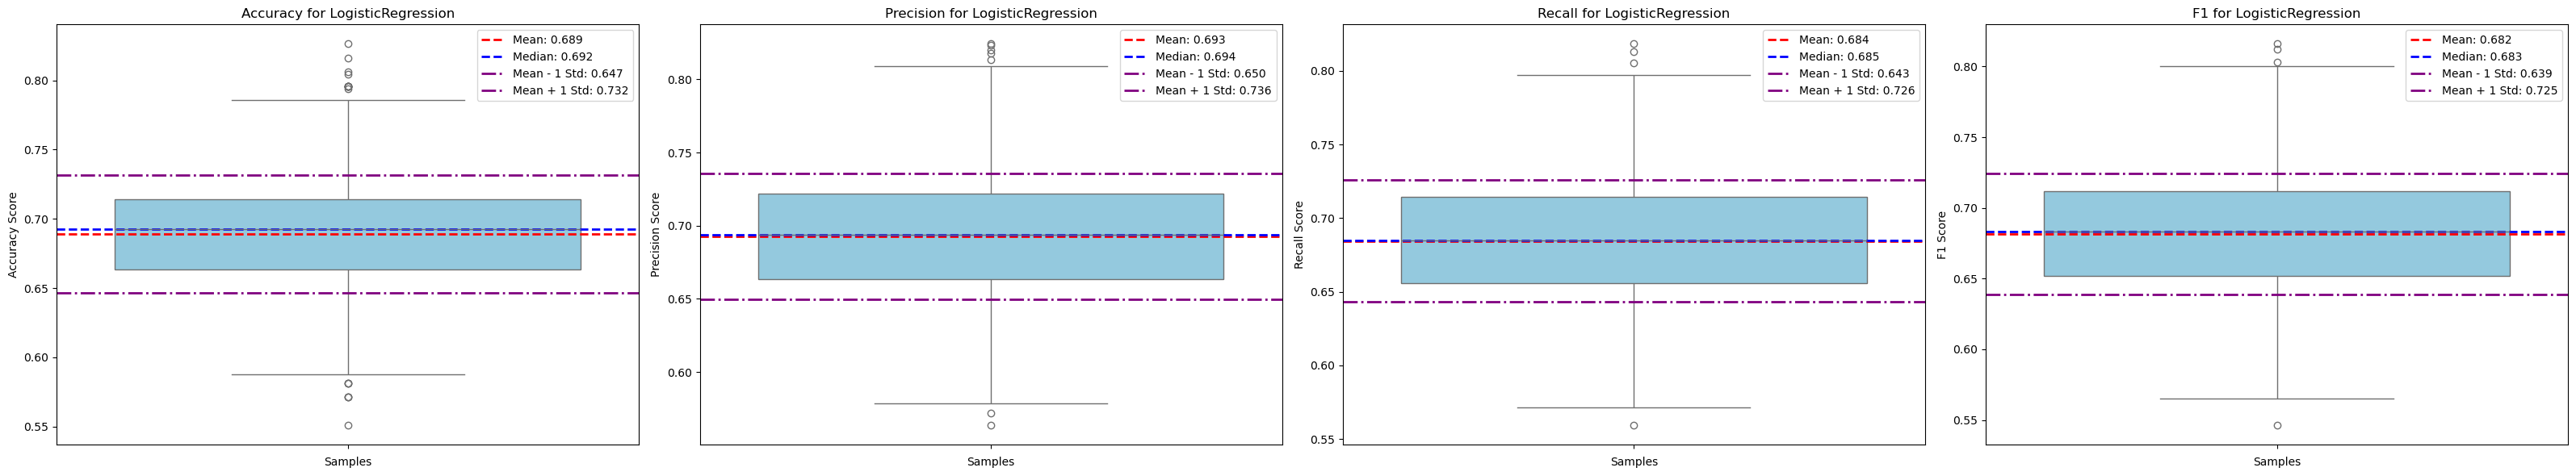

GaussianNB


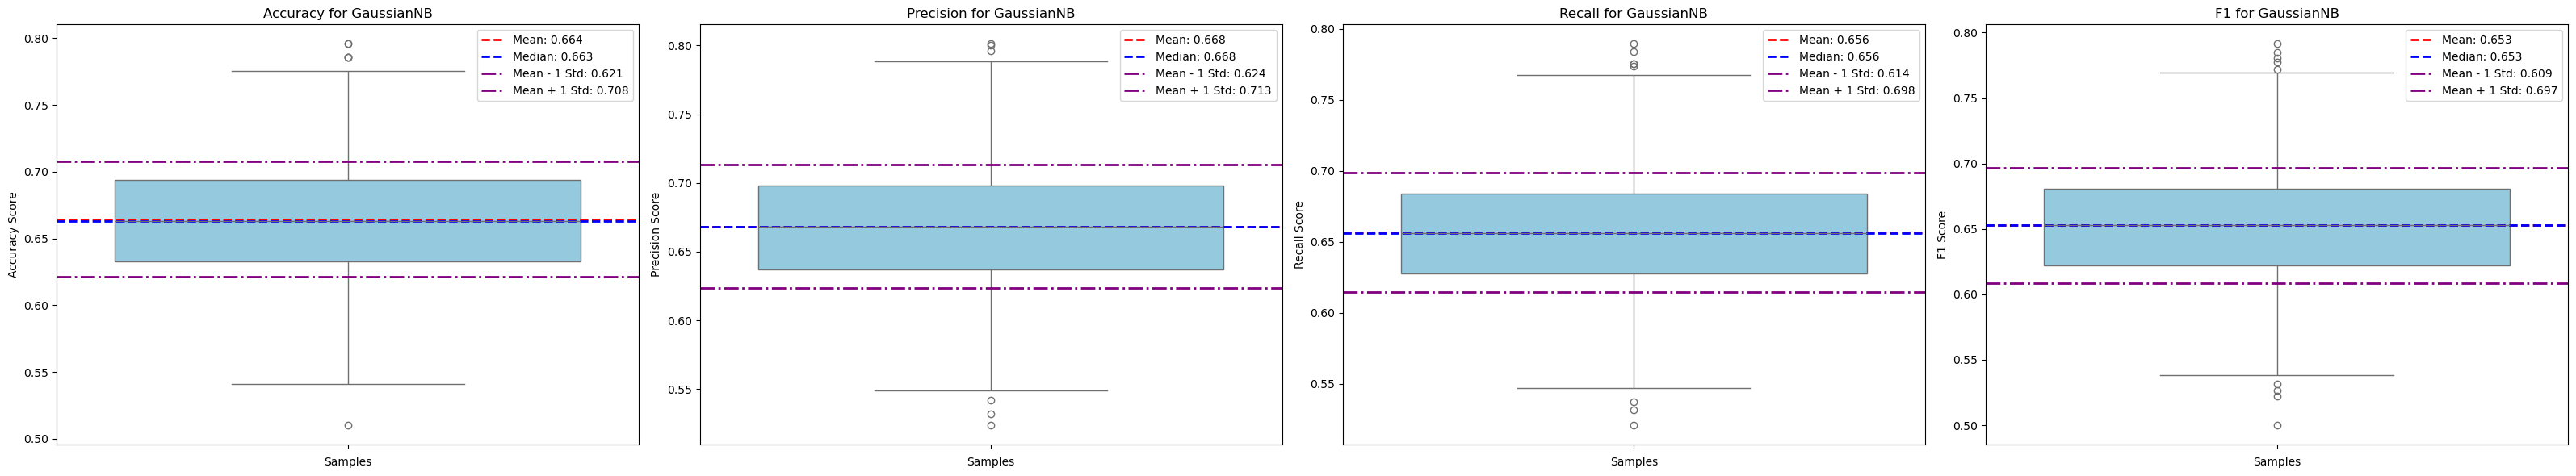

In [9]:
models = [LogisticRegression(), GaussianNB()]
for model in models:
    print(model.__class__.__name__)
    if model.__class__.__name__ == 'LogisticRegression':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=KernelPCA(kernel='poly', n_components=79, degree=3))
    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=SelectKBest(score_func=f_classif, k=94))
    functions.bootstrap2boxplot(x, y, x_val, y_val, pipeline, n_iter=200, bstrap=False, kf=True, root_path=root, filename=f"baseline_{model.__class__.__name__}_fs.pkl", save=True, default_path=True, classif=True)

<p>The results after using optuna to find the best feature selection method for our dataset by maximizing the F1 score failed to improve the metrics, however this might mean that we have successfully managed to reduce dimensions which will help in the next steps.</p>

LogisticRegression


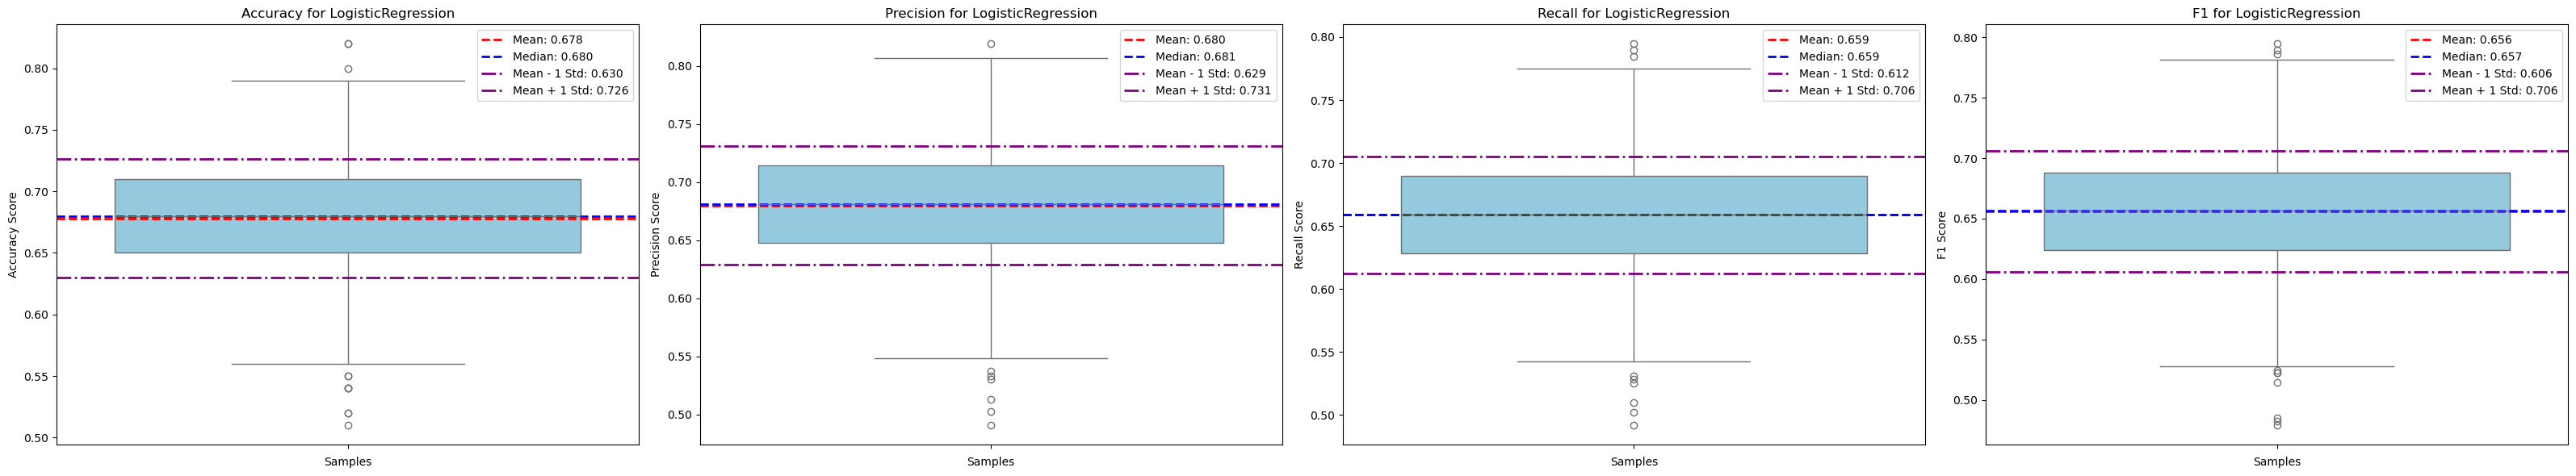

GaussianNB


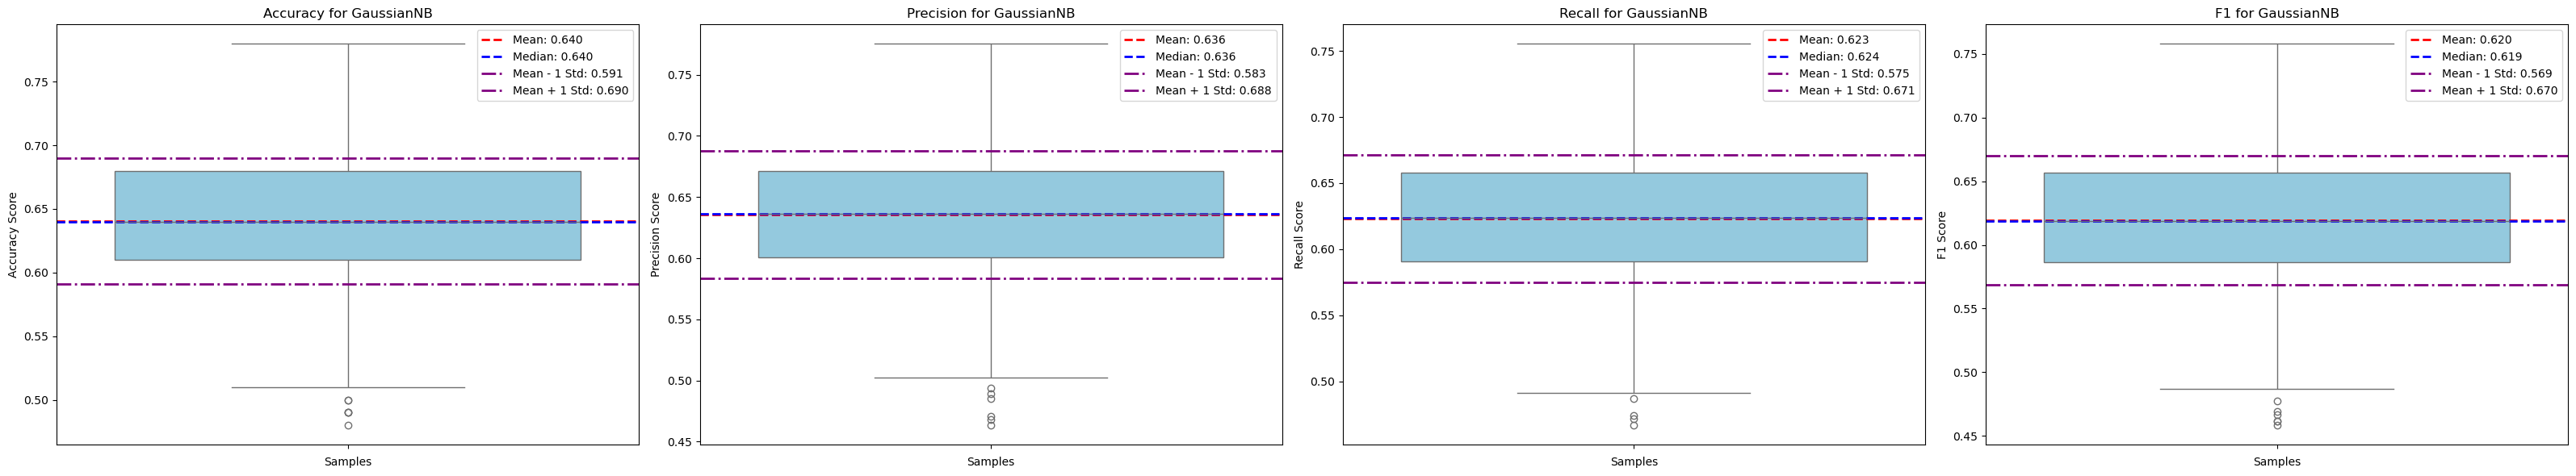

In [12]:
models = [LogisticRegression(), GaussianNB()]
for model in models:
    print(model.__class__.__name__)
    if model.__class__.__name__ == 'LogisticRegression':
        pipeline = functions.create_pipeline(model=model, scaler=False, feature_selector=KernelPCA(kernel='poly', n_components=79, degree=3))
    else:
        pipeline = functions.create_pipeline(model=model, scaler=False, feature_selector=SelectKBest(score_func=f_classif, k=94))
    functions.bootstrap2boxplot(
        x, y,
        x_val, y_val,
        pipeline, n_iter=1000,
        bstrap=True, kf=False,
        classif = True, save = False
    )

<hr>

### Fine Tuning

<p>Below we perform fine tuning with optuna to find the best hyperparameters that maximize the F1 score. As can be seen, the results did not improve. This can once again be attributed to the exclusion of factors like Sex and Age which might help to improve predictions or to the models being unable to properly converge for the given task.</p>

In [4]:
models = [LogisticRegression(), GaussianNB()]
for model in models:
    print(f"Model: {model.__class__.__name__}")
    if model.__class__.__name__ == 'LogisticRegression':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=KernelPCA(kernel='poly', n_components=79, degree=3))
    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=SelectKBest(score_func=f_classif, k=94))
    study = optuna.create_study(direction="maximize")
    # I had to use chatgpt for the following line, to figure out how to pass the model and x and y to the optuna_objective function
    study.optimize(lambda trial: functions.optuna_objective(trial, model, x, y, pipeline, classif=True, scoring='f1_macro'), n_trials=100)
    # Best hyperparameters
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
            print(f"    {key}: {value}")

[I 2025-03-31 19:39:22,771] A new study created in memory with name: no-name-91abcdb0-fe31-4d03-b9e4-60c4a26b7493


Model: LogisticRegression


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_mode

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.6867294621007781
  Params: 
    C: 1.3842844870001867
    solver: lbfgs
Model: GaussianNB


[I 2025-03-31 19:43:27,899] Trial 0 finished with value: 0.6550544878617599 and parameters: {'var_smoothing': 1.6467510268668053e-11}. Best is trial 0 with value: 0.6550544878617599.
[I 2025-03-31 19:43:28,109] Trial 1 finished with value: 0.6548052088348463 and parameters: {'var_smoothing': 5.1296324586148006e-08}. Best is trial 0 with value: 0.6550544878617599.
[I 2025-03-31 19:43:28,314] Trial 2 finished with value: 0.6552501087203021 and parameters: {'var_smoothing': 3.5434753446118546e-10}. Best is trial 2 with value: 0.6552501087203021.
[I 2025-03-31 19:43:28,522] Trial 3 finished with value: 0.6550544878617599 and parameters: {'var_smoothing': 1.6971463539395965e-11}. Best is trial 2 with value: 0.6552501087203021.
[I 2025-03-31 19:43:28,728] Trial 4 finished with value: 0.6548052088348463 and parameters: {'var_smoothing': 4.592829698447159e-08}. Best is trial 2 with value: 0.6552501087203021.
[I 2025-03-31 19:43:28,932] Trial 5 finished with value: 0.6550288908172949 and parame

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.6552718142247173
  Params: 
    var_smoothing: 5.685020742036095e-12


LogisticRegression


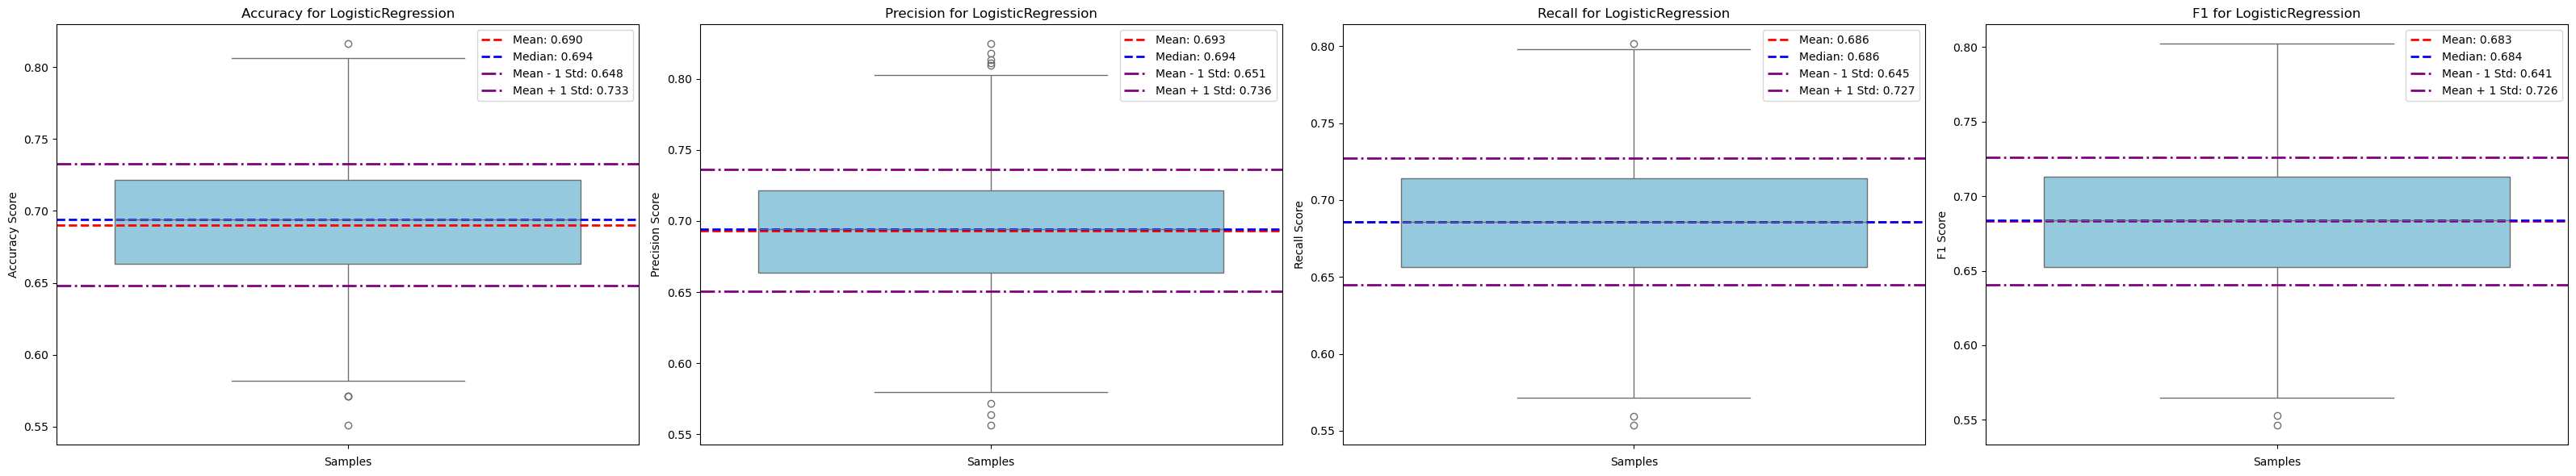

GaussianNB


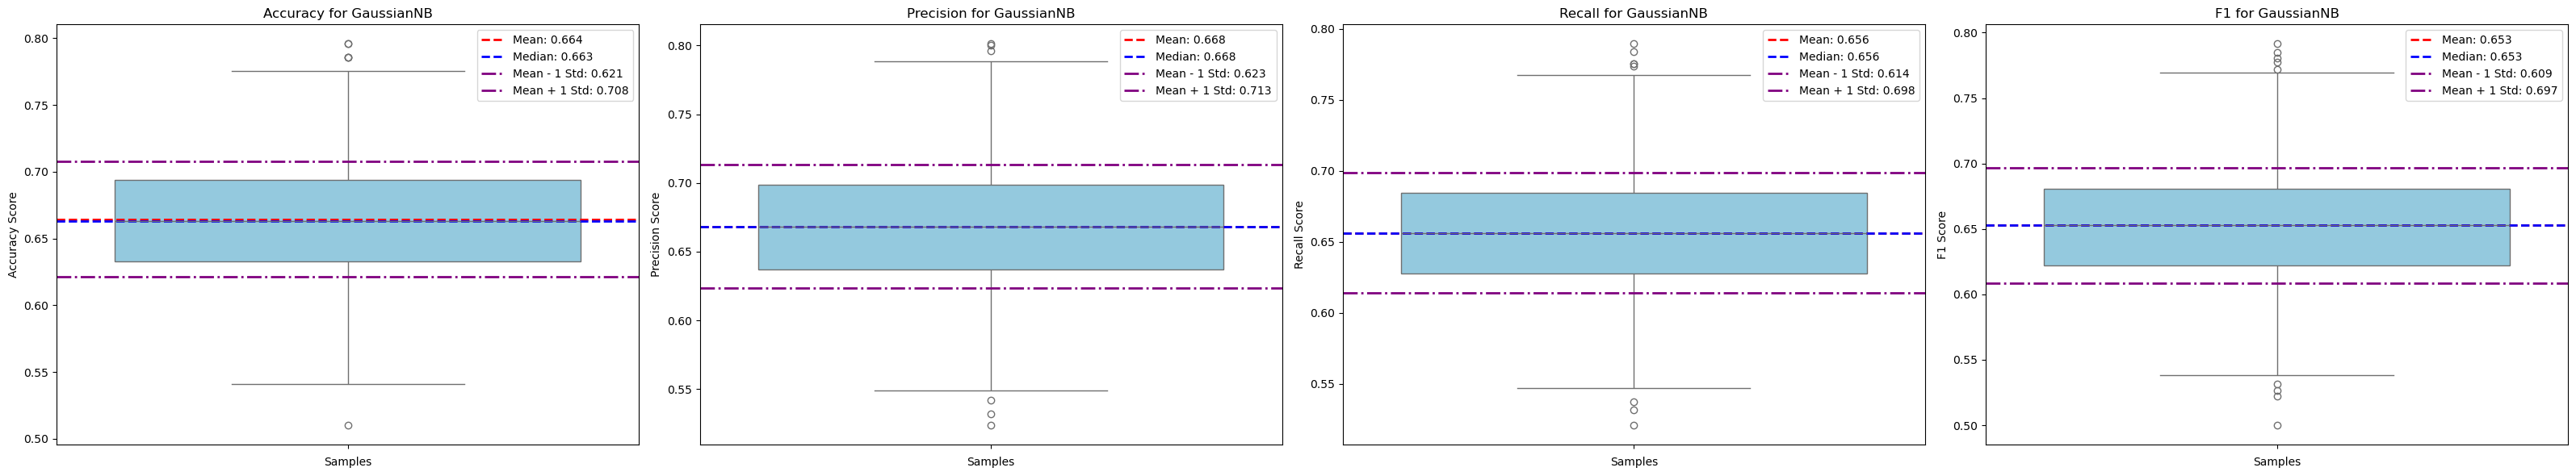

In [5]:
models = [LogisticRegression(C=1.3842844870001867), GaussianNB(var_smoothing=5.685020742036095e-12)]
for model in models:
    print(model.__class__.__name__)
    if model.__class__.__name__ == 'LogisticRegression':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=KernelPCA(kernel='poly', n_components=79, degree=3))
    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=SelectKBest(score_func=f_classif, k=94))
    functions.bootstrap2boxplot(x, y, x_val, y_val, pipeline, n_iter=200, bstrap=False, kf=True, root_path=root, filename=f"{model.__class__.__name__}_optuna.pkl", save=True, default_path=True, classif=True)

LogisticRegression


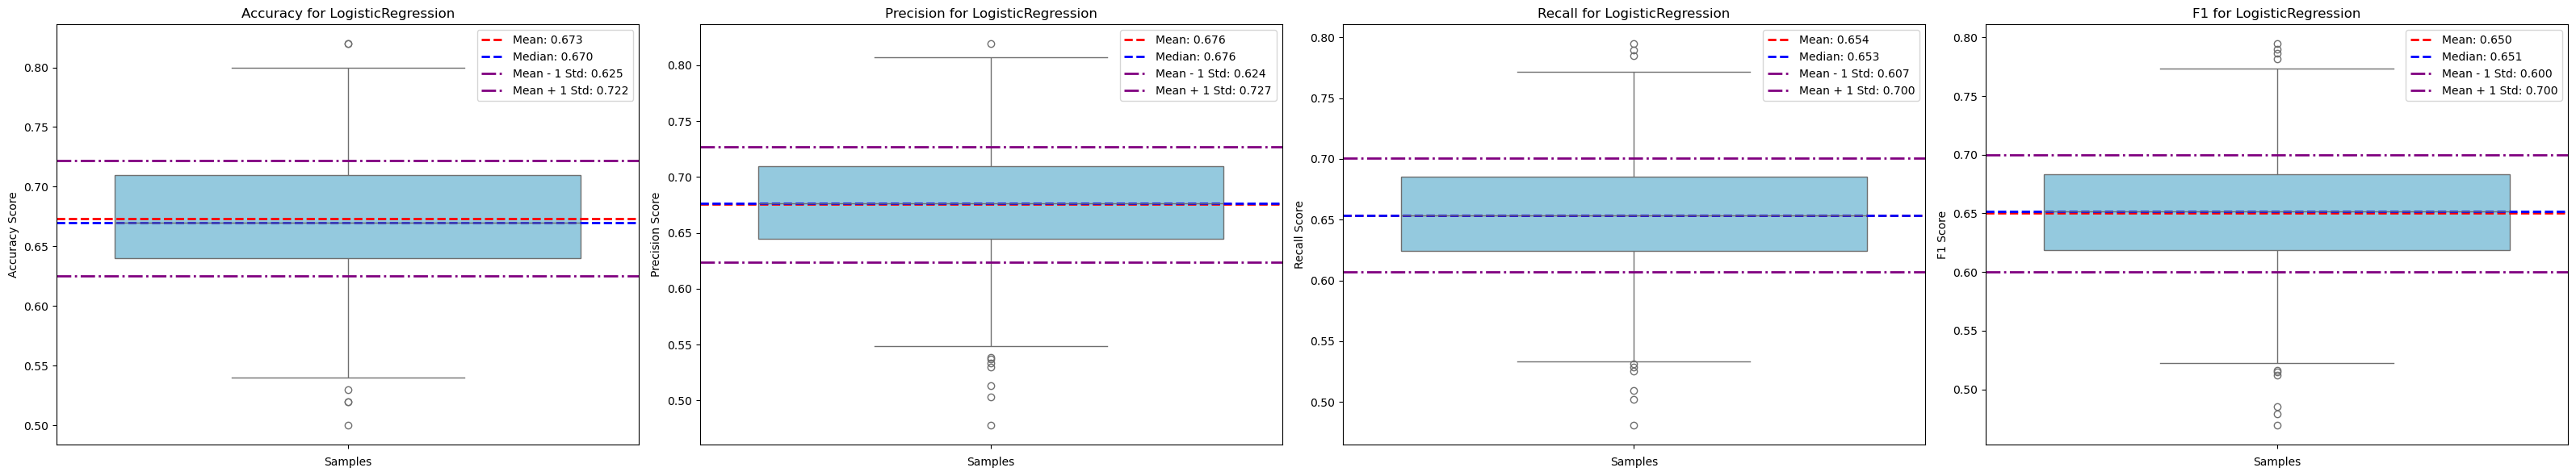

GaussianNB


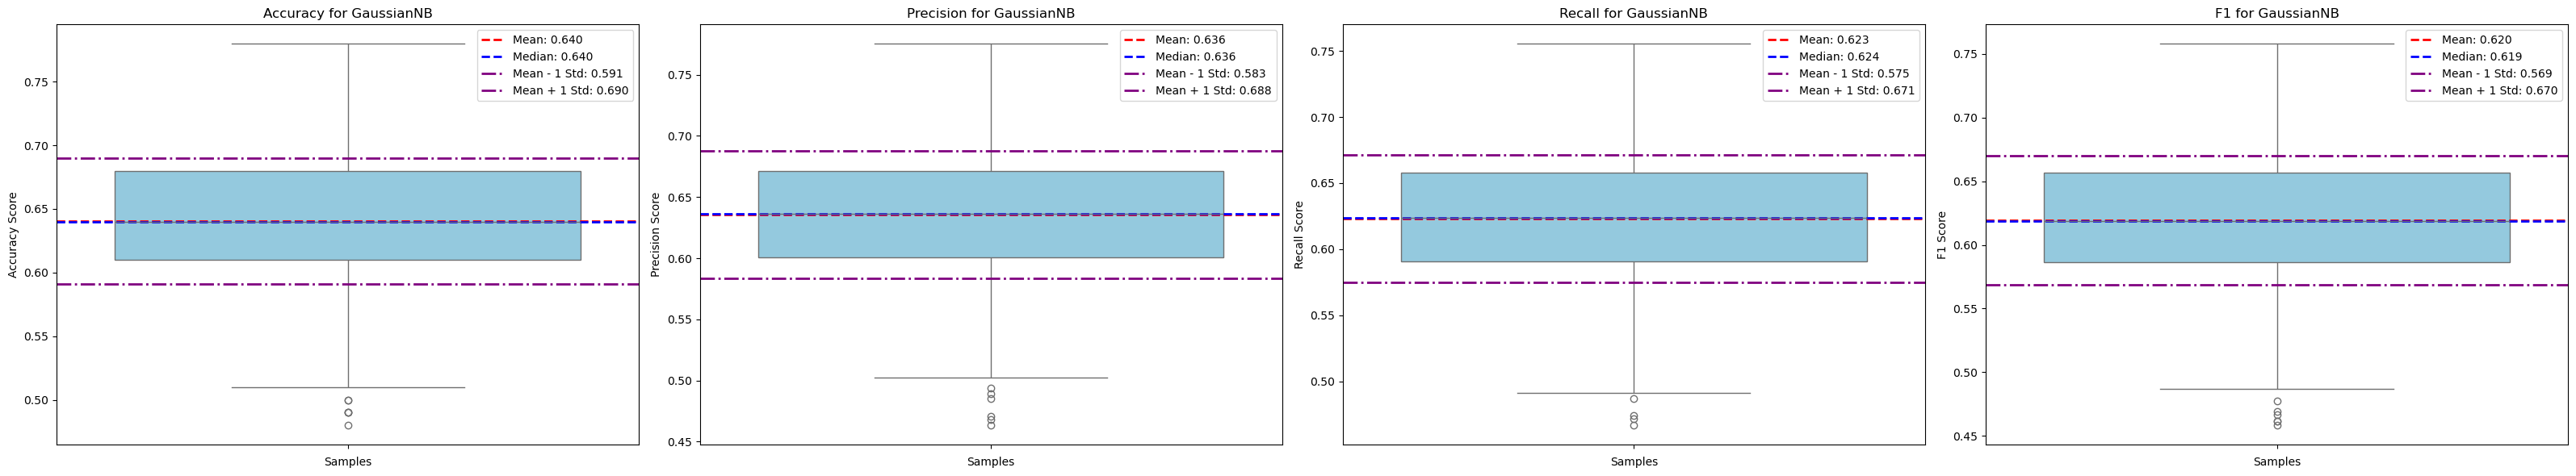

In [7]:
models = [LogisticRegression(C=1.3842844870001867), GaussianNB(var_smoothing=5.685020742036095e-12)]
for model in models:
    print(model.__class__.__name__)
    if model.__class__.__name__ == 'LogisticRegression':
        pipeline = functions.create_pipeline(model=model, scaler=False, feature_selector=KernelPCA(kernel='poly', n_components=79, degree=3))
    else:
        pipeline = functions.create_pipeline(model=model, scaler=False, feature_selector=SelectKBest(score_func=f_classif, k=94))
    functions.bootstrap2boxplot(
        x, y,
        x_val, y_val,
        pipeline, n_iter=1000,
        bstrap=True, kf=False,
        classif = True, save = False
    )